## Figure 2 Generation Notebook
This notebook will generate the arrhenius prediction figure

In [1]:
#Handle general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import sys
from scipy.interpolate import interp1d
from scipy.stats import pearsonr


import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

structuring_code_path = "../structuring_code/"
sum_path = "../joule_declass_sum/"
raw_path = "../joule_declass_raw/"
joule_cell_id_path =  "../Joule_cell_id.csv"
sys.path.insert(0, structuring_code_path)

In [2]:
#Load functions from modules of interest
from Joule_sum_data_builder import load_sum_obj
from plotting_and_fitting_helpers import local_reg_adjust_window, get_smoothed_cap_eol_time, get_mean_trend

In [3]:
joule_cell_id_df = pd.read_csv(joule_cell_id_path)
joule_cell_id_df.head()


,Cell_type,Cell_chemistry,Form_factor,Approximate Recording Frequency,Test_id,SOC,Temperature,Cell_id,Lot,Comment
0,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00001,L001,NaN
1,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00002,L001,NaN
2,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00003,L001,NaN
3,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00004,L001,NaN
4,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00005,L001,NaN


In [4]:
#Set plotting parameters
font_size_set = 8

plt.rc('font', size=font_size_set)          # controls default text sizes
plt.rc('axes', titlesize=font_size_set)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_set)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size_set)    # legend fontsize
plt.rc('figure', titlesize=font_size_set)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rc("lines", lw=1.5)


alpha = 0.7

In [5]:
def get_predicted_temperature(cell_type, soc, joule_cell_id_df, higher_temp_to_use = [45, 60], extrap_temp = 24):
    """
    This function will get the predicted capacity degradation curve at a given temperature 
    using the higher temperatures that are available in the data. 

    Inputs:
    @cell_type(str): cell_type to load data from. ex: "K2 Energy LFP18650E"
    @soc(int): soc to load data from
    @joule_cell_id_df(pd.Dataframe): Dataframe containing all cell ids and corresponding cell types
    @higher_temp_to_use([int]): the temperatures to use to fit arrhenius slope to
    @extrap_temp(int): The temperature to predict using the arrhenius slope fit on 
                        higher_temp_to_use temperatures. 

    Returns:
    @time_array(np.array): Time array in weeks
    @cap_24C_predicted_array(np.array): Capacity(%) array corresponding to time_array. 
    """
    
    CELCIUS_TO_KEVLIN = 273.15

    metric="RPT0.2C_2_D_capacity"
    filtered = True

    condition = (joule_cell_id_df["SOC"]==soc) & (joule_cell_id_df["Cell_type"]==cell_type) & (joule_cell_id_df["Temperature"].isin(higher_temp_to_use))
    cell_id_list = list(joule_cell_id_df[condition]["Cell_id"])
    sum_obj_list = [x for x in os.listdir(sum_path) if str(x.split("_")[0]) in cell_id_list]

    all_cell_id_cap_dict = {} 

    longest_testing_time = 0

    #Initialize dictionaries
    for temp in higher_temp_to_use:
        all_cell_id_cap_dict[temp] = {}

    #Loop through all data and find the longest time that was tested as well as store data in dictionary
    #to not need to reload the data in further parts
    for idx in tqdm(range(len(sum_obj_list))):
        sum_name = sum_obj_list[idx]
        sum_obj=load_sum_obj(file_path=sum_path+sum_name)
        df = sum_obj.summary_data
        metric_points = df[metric]
        time_points = np.array(df["Calendar_DateTime(days)"])/7
        cell_id = sum_name.split("_")[0]
        temp = joule_cell_id_df[joule_cell_id_df["Cell_id"]==str(cell_id)]["Temperature"].iloc[0]

        if filtered:
            if(len(time_points))<4:
                continue
            
            rel_metric_points = (metric_points/metric_points[0])*100
            rel_smoothed_metric_points = local_reg_adjust_window(time_points, rel_metric_points, deg=2)
            time_to_plot = time_points
            metric_to_plot = rel_smoothed_metric_points

        EOT_time = time_points[-1]
        if EOT_time> longest_testing_time:
            longest_testing_time = EOT_time

        all_cell_id_cap_dict[temp][sum_name] = {"EOT_time": EOT_time, "capacity[%]": metric_to_plot, "time(weeks)": time_to_plot}

    # Get mean degradation curves for 45C, 60C, and 85C at all timepoints up to the longest time tested
    #Starting this at 1 so that there is not issues at 0 time (all capacities are 100)
    time_array = np.linspace(1, longest_testing_time, 1000)
    cap_loss_mean_dict = {}
    for temp in higher_temp_to_use:

        temp_cap_data = all_cell_id_cap_dict[temp]

        if len(temp_cap_data)==0:
            continue

        #initialize nan array to fill
        temp_cap_array = np.ones((len(temp_cap_data), len(time_array)))*np.nan
        for idx, cell_id in enumerate(temp_cap_data):
            cell_id_data = temp_cap_data[cell_id]

            time_points = cell_id_data["time(weeks)"]
            cap_perc_points = cell_id_data["capacity[%]"]
            cap_fun = interp1d(time_points, cap_perc_points, fill_value=np.nan, bounds_error=False)
            cap_array = cap_fun(time_array)

            temp_cap_array[idx,:]=cap_array
        #add the cap loss to the array now
        cap_loss_mean_dict[temp] = 100 - np.nanmean(temp_cap_array, axis=0)


    ### get the capacity loss that should occur at extrapolated temperature(24C usually) 
    # via Arrhenius prediction
    cap_loss_predicted_array = np.zeros(len(time_array))
    temp_values =  np.array(list(cap_loss_mean_dict.keys()))
    inverse_T_list = (1/(temp_values+CELCIUS_TO_KEVLIN))
    inverse_T_predicted = (1/(extrap_temp+CELCIUS_TO_KEVLIN))
    inverse_T_24C = (1/(24+CELCIUS_TO_KEVLIN))

    #non-24C temperature values
    if len(temp_values)<2:
        raise Exception("Too few temperature for extrapolation")

    for idx in range(len(time_array)):
        cap_at_time_loss_array = []
        for temp in temp_values:
            cap_at_time_loss_array.append(cap_loss_mean_dict[temp][idx])

        #needs 2 or more non nan values for mean cap loss. This will also
        #filter nan values out when using poly fit. otherwise it will fail
        log_cap_loss_array = np.log(cap_at_time_loss_array)
        non_nan_idx = np.isfinite(log_cap_loss_array)
        if sum(non_nan_idx) < 2:
            cap_loss_predicted_array[idx] = np.nan
            continue

        slope, intercept = np.polyfit(inverse_T_list[non_nan_idx], log_cap_loss_array[non_nan_idx], 1)
        log_cap_loss24C = slope*inverse_T_24C + intercept
        cap_loss_predicted_array[idx] = np.exp(log_cap_loss24C)

    cap_24C_predicted_array = 100-cap_loss_predicted_array
    return time_array, cap_24C_predicted_array


100%|██████████| 14/14 [00:00<00:00, 84.46it/s]
/var/folders/k9/hy9cs3b54pq88xpmlpdhl3c40000gn/T/ipykernel_82862/2858431106.py:114: RuntimeWarning: Mean of empty slice
  mean_cap_loss = np.nanmean(cap_loss_array)


C00047_sum.json
C00047_sum.json
C00047_sum.json
C00047_sum.json
[-3.04844623 11.27166157]
pearson:PearsonRResult(statistic=np.float64(-0.9829644564248985), pvalue=np.float64(0.11767700054811532))
[-2.88801858 11.20852139]
pearson:PearsonRResult(statistic=np.float64(-0.9977252137068181), pvalue=np.float64(0.04294847857243541))
[-2.64427952 10.76049239]
pearson:PearsonRResult(statistic=np.float64(-0.999441742516529), pvalue=np.float64(0.021273189248662887))
[-3.32518159 13.19596246]
pearson:PearsonRResult(statistic=np.float64(-0.9647155323250405), pvalue=np.float64(0.1696181159859713))


100%|██████████| 6/6 [00:00<00:00, 81.46it/s]
/var/folders/k9/hy9cs3b54pq88xpmlpdhl3c40000gn/T/ipykernel_82862/3536668790.py:85: RuntimeWarning: Mean of empty slice
  cap_loss_mean_dict[temp] = 100 - np.nanmean(temp_cap_array, axis=0)


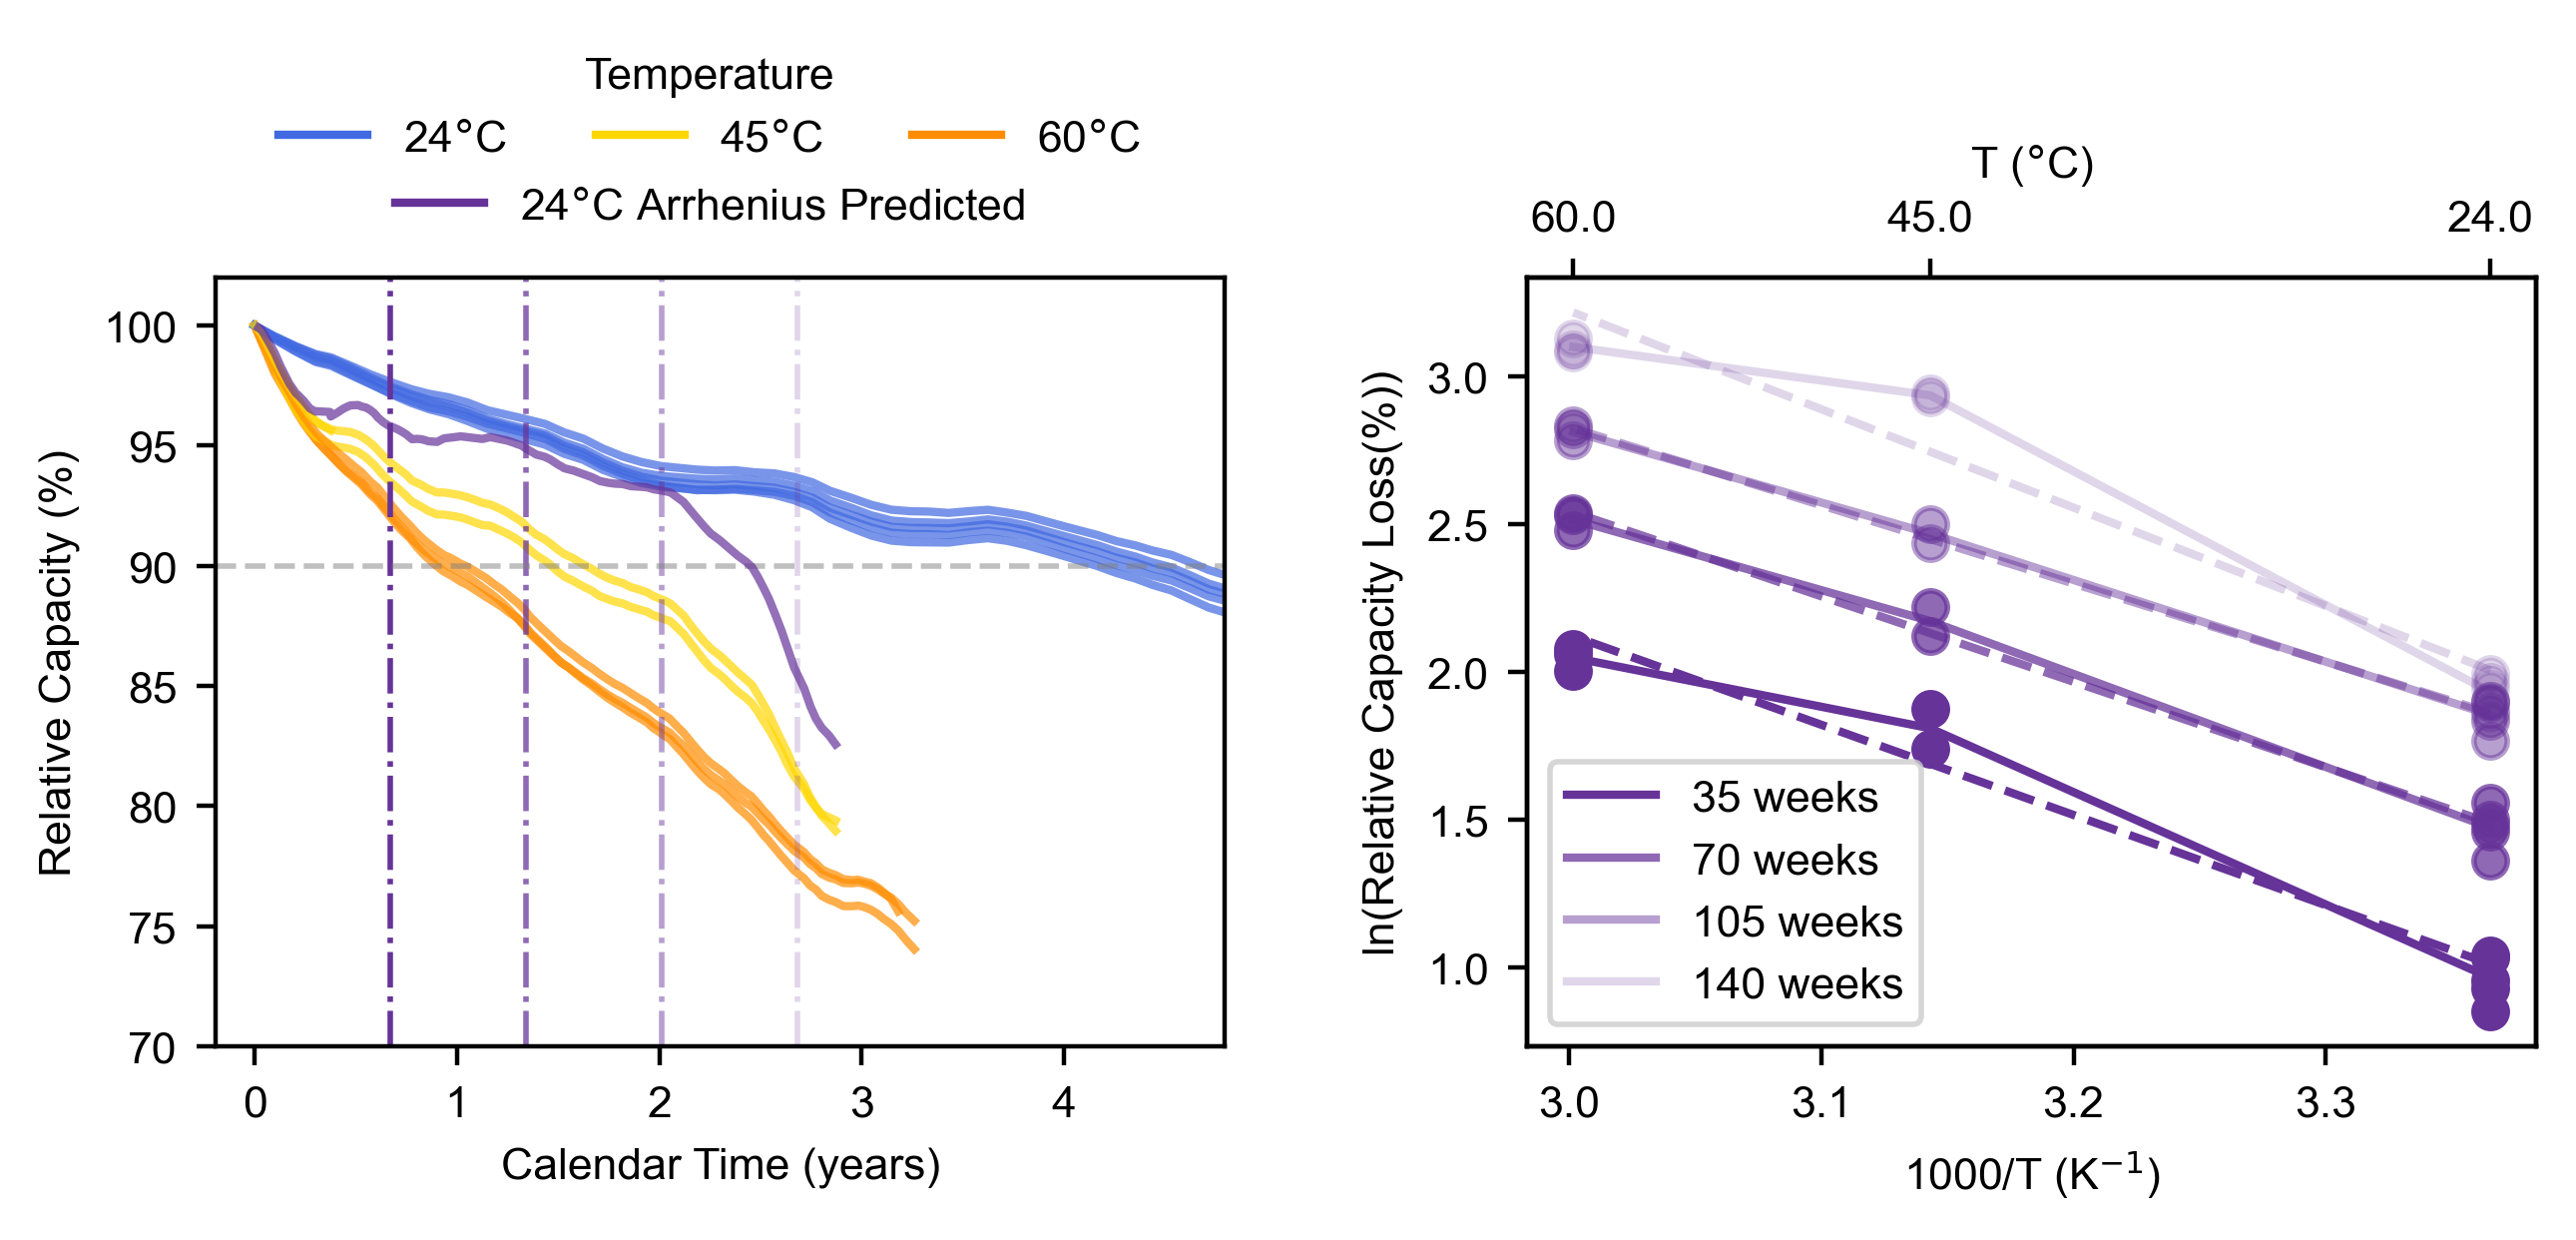

In [6]:
#Choose cell to show
cell_type = "Panasonic NCR18650B"
soc = 50

filtered=True
metric="RPT0.2C_2_D_capacity"
color_list = ["royalblue", "gold", "darkorange", "firebrick"]

#Get file names to load
condition = (joule_cell_id_df["SOC"]==soc) & (joule_cell_id_df["Cell_type"]==cell_type)
cell_id_list = list(joule_cell_id_df[condition]["Cell_id"])
sum_obj_list = [x for x in os.listdir(sum_path) if str(x.split("_")[0]) in cell_id_list]

temp_list = [24, 45, 60, 85]
marker_size = 7
# linewidth = 0.2
fig,axs = plt.subplots(1,2,figsize=(7.5,2.5), dpi=400)

ax = axs[0]

#This is used in later cells as well, used for consistency on where the dashed lines are placed
cap_to_check = [97.5, 95, 92.5, 90]
time_to_check = [35, 70, 105, 140] #For panasonic 18650B 50SOC, in weeks

xlim1 = np.array([-10, 250])/52.1429 #in weeks
ylim2 = [70, 102]
min_data_to_smooth = 10
nominal_window_size = 14
alpha=0.7

time_to_reach_cap = []
temperature_array = []
time_to_cap_dict = {}
cap_at_time_dict = {}
for time in time_to_check:
    cap_at_time_dict[time]= {}
    for temp in temp_list:
        cap_at_time_dict[time][temp] = []
for cap in cap_to_check:
    time_to_cap_dict[cap]= []

for idx in tqdm(range(len(sum_obj_list))):
    sum_name = sum_obj_list[idx]
    sum_obj=load_sum_obj(file_path=sum_path+sum_name)
    df = sum_obj.summary_data
    metric_points = df[metric]
    #make this in years so it's simpler
    time_points = np.array(df["Calendar_DateTime(days)"])/7 #in weeks

    if filtered:
        if(len(time_points))<4:
            continue

        rel_metric_points = (metric_points/metric_points[0])*100
        rel_smoothed_metric_points = local_reg_adjust_window(time_points, rel_metric_points, deg=2)
        time_to_plot = time_points
        metric_to_plot = rel_smoothed_metric_points
        time_fun = interp1d(metric_to_plot, time_to_plot)
        cap_fun = interp1d(time_to_plot, metric_to_plot)
        
    else:
        time_to_plot = time_points
        metric_to_plot = (metric_points/metric_points[0])*100


        time_fun = interp1d(metric_to_plot, time_to_plot)
        cap_fun = interp1d(time_to_plot, metric_to_plot)


    cell_id = sum_name.split("_")[0]
    temp = joule_cell_id_df[joule_cell_id_df["Cell_id"]==str(cell_id)]["Temperature"].iloc[0]
    color = color_list[temp_list.index(temp)]
    #plot vs years so divide
    ax.plot(time_points/52.1429, metric_to_plot, color=color, alpha = alpha)

    for time in time_to_check:
        try:
            #Fill in different function
            cap_at_time_dict[time][temp].append(cap_fun(time))
        except:
            cap_at_time_dict[time][temp].append(np.nan)
            print(sum_name)
            continue

    temperature_array.append(temp)


ax.set_ylim(ylim2)
ax.set_xlim(xlim1)


alpha_array = np.linspace(1, 0.2, len(time_to_check))
for idx, time in enumerate(time_to_check):
    ax.axvline(time/52.1429, color="rebeccapurple", alpha=alpha_array[idx], linestyle="dashdot", linewidth=1)

ax.axhline(90, color="gray", alpha=0.5, linestyle="dashed", linewidth=1)
ax.set_ylabel("Relative Capacity (%)")
ax.set_xlabel("Calendar Time (years)")


### Plot the Arrhenius Dependence
#ignore the 85C
unique_temp = np.array([24,45,60])
color = "rebeccapurple"

ax = axs[1]
for idx, time in enumerate(cap_at_time_dict.keys()):
    mean_cap_loss_array = []

    cap_temp_dict = cap_at_time_dict[time]

    for temp in temp_list:
        cap_loss_array = 100 - np.array(cap_temp_dict[temp])
        mean_cap_loss = np.nanmean(cap_loss_array)
        mean_cap_loss_array.append(mean_cap_loss)
        inverse_temp_k = (1/(temp+273.15))*1000 #1000/K

        ax.scatter([inverse_temp_k]*len(cap_loss_array), np.log(cap_loss_array), color=color, alpha=alpha_array[idx])

    x = (1/(np.array(temp_list)+273.15))*1000 #[1000/K]
    y = np.log(mean_cap_loss_array)
    #drop nans present in y if data was not available
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]

    ax.plot(x, y, color=color, alpha=alpha_array[idx], label="{0} weeks".format(time))
    #plot line of best fit
    coeff = np.polyfit(x, y, 1)
    print(coeff)
    print("pearson:{}".format(pearsonr(x, y)))
    ax.plot(x, coeff[0]*x + coeff[1], color=color, alpha=alpha_array[idx], linestyle="--")

ax.legend(loc="lower left")

#This is for adding top label
ax_twin = ax.twiny()
#transform to bottom axis
def inverse_T(x):
    return 1000/(x+273.15)

ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xlabel(r"T ($\degree$C)")

x_ticks = np.array([24, 45, 60])  # Define the desired tick positions
ax_twin.set_xticks(inverse_T(x_ticks))  # Convert tick positions using the forward transformation
ax_twin.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])  # Set tick labels

ax.set_ylabel("ln(Relative Capacity Loss(%))")
ax.set_xlabel(r"1000/T (K$^{-1}$)")

plt.subplots_adjust(wspace=0.3)


#### Over here extract the Arrhenius temperature, and add it axs[0]
arrh_time_array, arrh_cap_24C_predicted_array = get_predicted_temperature(cell_type, soc, joule_cell_id_df, higher_temp_to_use = [45, 60], extrap_temp = 24)
axs[0].plot(arrh_time_array/52.1429, arrh_cap_24C_predicted_array, color="rebeccapurple", alpha=alpha)


#add legend
temp_24 = Line2D([0], [0], label=r'24$\degree$C', color=color_list[0])
temp_45 = Line2D([0], [0], label=r'45$\degree$C', color=color_list[1])
temp_60 = Line2D([0], [0], label=r'60$\degree$C', color=color_list[2])
temp_24_arrh = Line2D([0], [0], label=r'24$\degree$C Arrhenius Predicted', color="rebeccapurple")

legend_x_pos = 0.29
fig.legend(handles=[temp_24, temp_45, temp_60], loc='center', bbox_to_anchor=(legend_x_pos, 1.05), ncol=4, title="Temperature", frameon=False)
fig.legend(handles=[temp_24_arrh], bbox_to_anchor=(legend_x_pos, 0.95),loc='center', frameon=False)

#fig.savefig('../figures/figure2_Arrhenius_prediction_a.svg', format="svg", transparent=True, bbox_inches='tight')

100%|██████████| 10/10 [00:00<00:00, 67.72it/s]
/var/folders/k9/hy9cs3b54pq88xpmlpdhl3c40000gn/T/ipykernel_82862/3536668790.py:85: RuntimeWarning: Mean of empty slice
  cap_loss_mean_dict[temp] = 100 - np.nanmean(temp_cap_array, axis=0)
100%|██████████| 10/10 [00:00<00:00, 67.12it/s]
/var/folders/k9/hy9cs3b54pq88xpmlpdhl3c40000gn/T/ipykernel_82862/3536668790.py:85: RuntimeWarning: Mean of empty slice
  cap_loss_mean_dict[temp] = 100 - np.nanmean(temp_cap_array, axis=0)
100%|██████████| 10/10 [00:00<00:00, 78.11it/s]
/var/folders/k9/hy9cs3b54pq88xpmlpdhl3c40000gn/T/ipykernel_82862/3536668790.py:85: RuntimeWarning: Mean of empty slice
  cap_loss_mean_dict[temp] = 100 - np.nanmean(temp_cap_array, axis=0)
100%|██████████| 10/10 [00:00<00:00, 76.05it/s]
/var/folders/k9/hy9cs3b54pq88xpmlpdhl3c40000gn/T/ipykernel_82862/3536668790.py:85: RuntimeWarning: Mean of empty slice
  cap_loss_mean_dict[temp] = 100 - np.nanmean(temp_cap_array, axis=0)
100%|██████████| 6/6 [00:00<00:00, 83.10it/s]
/var/f

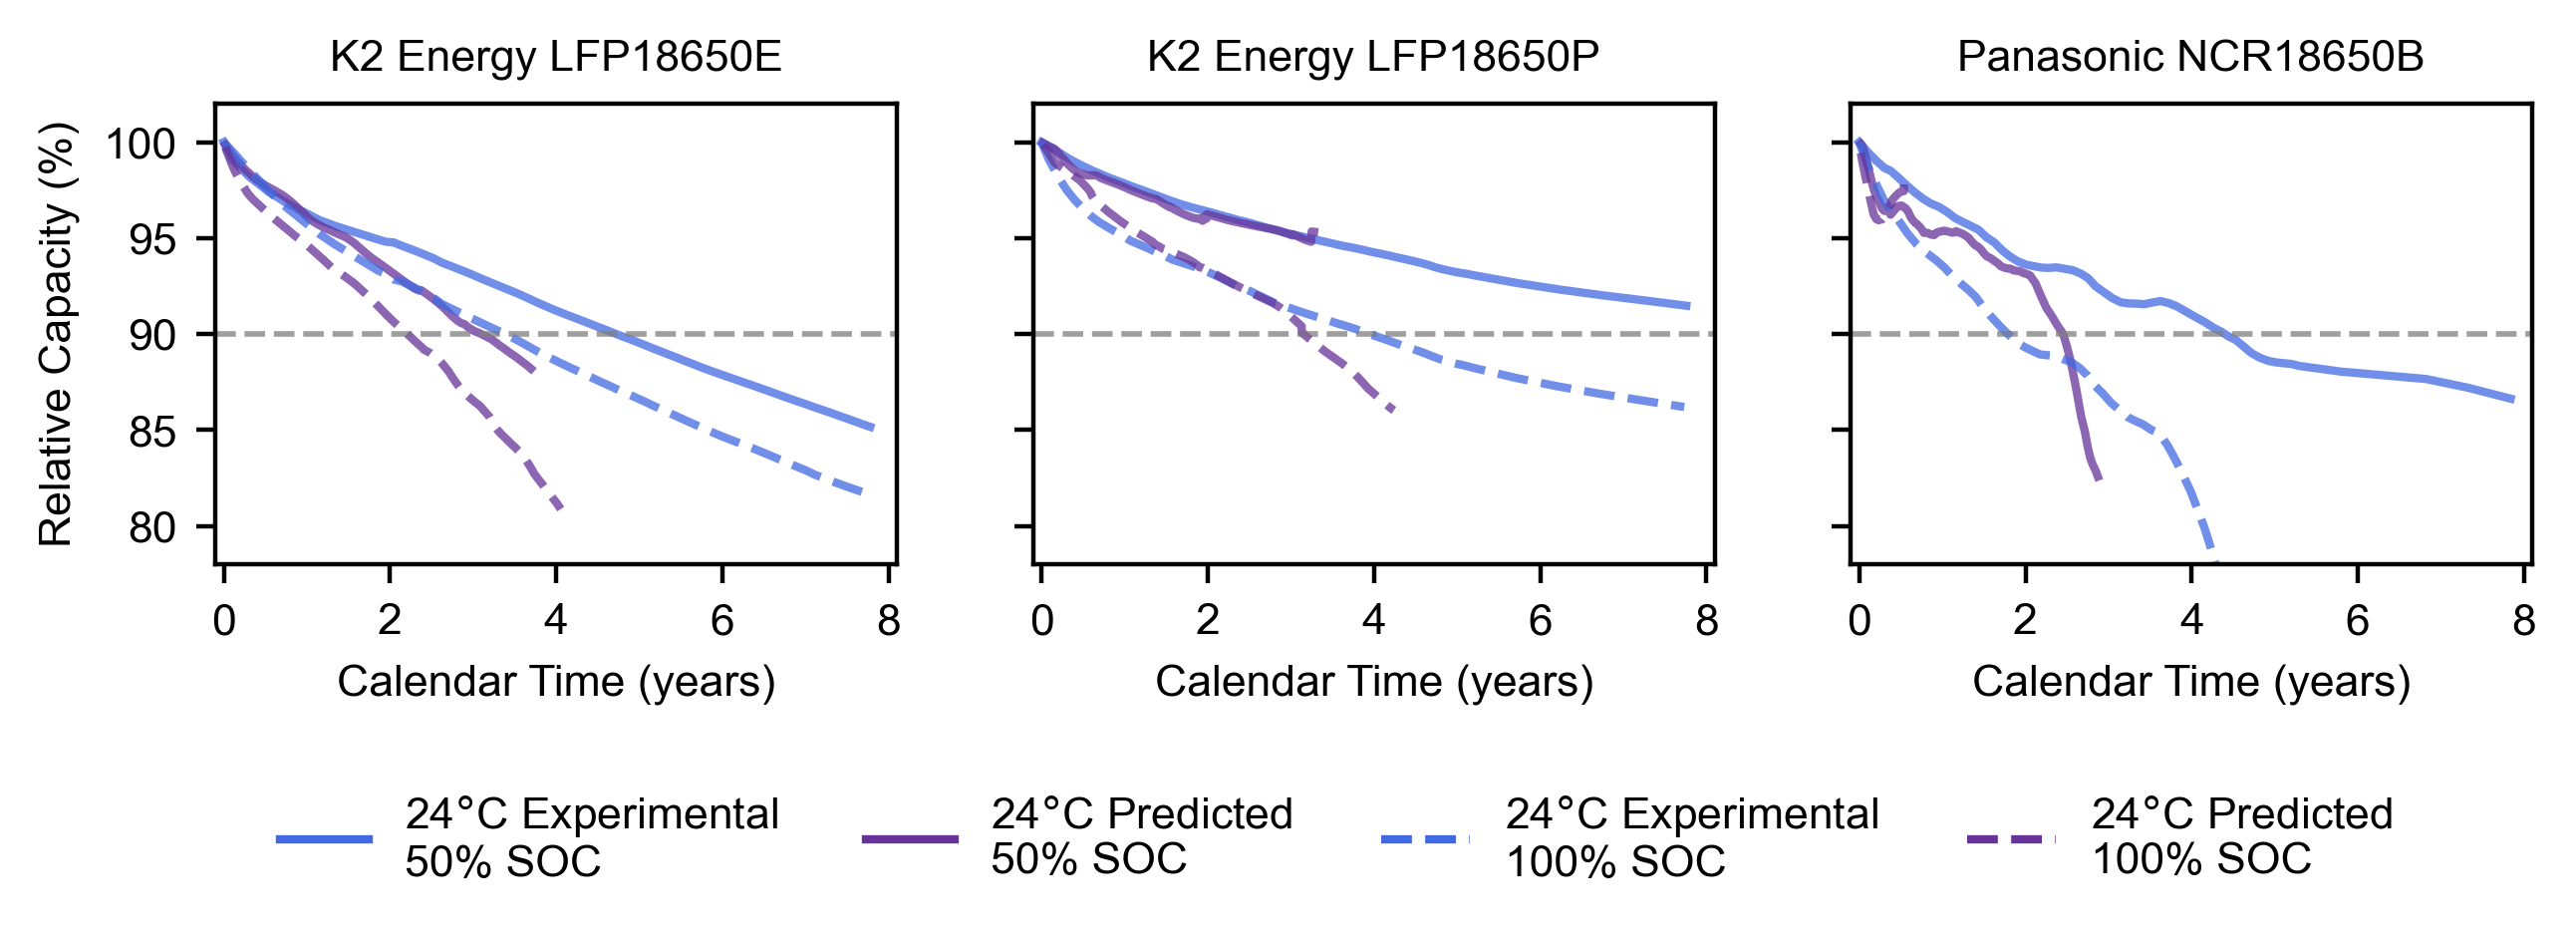

In [7]:
## Plotting 24C as mean

#First lets find some cells of interest and plot them
cell_type_Arrh_list = ["K2 Energy LFP18650E", "K2 Energy LFP18650P", "Panasonic NCR18650B"]
soc_list = [50, 100]
filtered=True
metric="RPT0.2C_2_D_capacity"
color_list = ["royalblue", "gold", "darkorange", "firebrick"]
linestyle_dict = {50:"-", 100:"--"}

num_cell_type = len(cell_type_Arrh_list)
fig,axs = plt.subplots(1,3,figsize=(7.5, 1.5), dpi=400, sharey=True, sharex=True)

for cell_type_idx, cell_type in enumerate(cell_type_Arrh_list):
    for soc_idx, soc in enumerate(soc_list):
        ax = axs[cell_type_idx]

        #Get 24C data
        condition = (joule_cell_id_df["SOC"]==soc) & (joule_cell_id_df["Cell_type"]==cell_type) & (joule_cell_id_df["Temperature"]==24)
        cell_id_list = list(joule_cell_id_df[condition]["Cell_id"])
        sum_obj_list = [x for x in os.listdir(sum_path) if str(x.split("_")[0]) in cell_id_list]
        #plot the 24C mean trend
        mean_cap_array, _, all_times, _ = get_mean_trend(sum_obj_list, sum_path, metric, normalize_before_mean=True)
        ax.plot(all_times/52.1429, mean_cap_array, color="royalblue", alpha=0.75, linestyle=linestyle_dict[soc])

        #plot the Arrhenius predicted trend. Ignore 85C
        higher_temp_to_use=[45, 60]
        time_24C_array, cap_24C_array = get_predicted_temperature(cell_type, soc, joule_cell_id_df, higher_temp_to_use=higher_temp_to_use, extrap_temp=24)
        ax.plot(time_24C_array/52.1429, cap_24C_array, color="rebeccapurple", alpha=0.75, linestyle=linestyle_dict[soc])

        ax.axhline(90, color="gray", alpha=0.5, linestyle="dashed", linewidth=1)
        ax.set_xlabel("Calendar Time (years)")
        
    axs[cell_type_idx].set_title("{}".format(cell_type))
    


axs[0].set_ylim([78, 102])
axs[0].set_xlim([-0.1,8.1])
axs[0].set_ylabel("Relative Capacity (%)")

#add legend
temp_24C_50 = Line2D([0], [0], label=r'24$\degree$C Experimental' "\n" "50% SOC", color="royalblue", linestyle="-")
temp_24C_ArrPred_50 = Line2D([0], [0], label=r'24$\degree$C Predicted' "\n" "50% SOC", color="rebeccapurple", linestyle="-")
temp_24C_100 = Line2D([0], [0], label=r'24$\degree$C Experimental' "\n" "100% SOC", color="royalblue", linestyle="--")
temp_24C_ArrPred_100 = Line2D([0], [0], label=r'24$\degree$C Predicted' "\n" "100% SOC", color="rebeccapurple", linestyle="--")


# Add legend to the figure
fig.legend(handles=[temp_24C_50, temp_24C_ArrPred_50, temp_24C_100, temp_24C_ArrPred_100], bbox_to_anchor=(0.5, -.35), loc="center", ncol=4, frameon=False)


#fig.savefig('../figures/figure2_Arrhenius_prediction_b.svg', format="svg", transparent=True, bbox_inches='tight')
